In [1]:
import networkx as nx
import itertools
import osmnx as ox
import glob
import itertools
from matplotlib import cm
import folium
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection
from osmnx.save_load import graph_to_gdfs
from torch_geometric.utils import from_networkx
import torch

%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')

In [2]:
def plot_graph(G, bbox=None, fig_height=6, fig_width=None, margin=0.02,
               axis_off=True, equal_aspect=False, bgcolor='w', show=True,
               save=False, close=True, file_format='png', filename='temp',
               dpi=300, annotate=False, node_color='#66ccff', node_size=15,
               node_alpha=1, node_edgecolor='none', node_zorder=1,
               edge_color='#999999', edge_linewidth=1, edge_alpha=1, edge_zorder=2,
               use_geom=True):

    #log('Begin plotting the graph...')
    node_Xs = [float(x) for _, x in G.nodes(data='x')]
    node_Ys = [float(y) for _, y in G.nodes(data='y')]

    # get north, south, east, west values either from bbox parameter or from the
    # spatial extent of the edges' geometries
    if bbox is None:
        edges = graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
        west, south, east, north = edges.total_bounds
    else:
        north, south, east, west = bbox

    # if caller did not pass in a fig_width, calculate it proportionately from
    # the fig_height and bounding box aspect ratio
    bbox_aspect_ratio = (north-south)/(east-west)
    if fig_width is None:
        fig_width = fig_height / bbox_aspect_ratio

    # create the figure and axis
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    ax.set_facecolor(bgcolor)

    # draw the edges as lines from node to node
    start_time = time.time()
    lines = []
    for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    if not isinstance(edge_color, list):
        edge_color = [edge_color] * len(lines)
    if not isinstance(edge_linewidth, list):
        edge_linewidth = [edge_linewidth] * len(lines)
    if not isinstance(edge_alpha, list):
        edge_alpha = [edge_alpha] * len(lines)
    if not isinstance(edge_zorder, list):
        edge_zorder = [edge_zorder] * len(lines)
        
    for i in range(len(lines)):
        lc = LineCollection(lines[i:i+1],
                            colors=edge_color[i:i+1],
                            linewidths=edge_linewidth[i:i+1], #TODO FIX!
                            alpha=edge_alpha[i],
                            zorder=edge_zorder[i])
        ax.add_collection(lc)
    #log('Drew the graph edges in {:,.2f} seconds'.format(time.time()-start_time))

    # scatter plot the nodes
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    # set the extent of the figure
    margin_ns = (north - south) * margin
    margin_ew = (east - west) * margin
    ax.set_ylim((south - margin_ns, north + margin_ns))
    ax.set_xlim((west - margin_ew, east + margin_ew))

    # configure axis appearance
    xaxis = ax.get_xaxis()
    yaxis = ax.get_yaxis()

    xaxis.get_major_formatter().set_useOffset(False)
    yaxis.get_major_formatter().set_useOffset(False)

    # if axis_off, turn off the axis display set the margins to zero and point
    # the ticks in so there's no space around the plot
    if axis_off:
        ax.axis('off')
        ax.margins(0)
        ax.tick_params(which='both', direction='in')
        xaxis.set_visible(False)
        yaxis.set_visible(False)
        fig.canvas.draw()

    if equal_aspect:
        # make everything square
        ax.set_aspect('equal')
        fig.canvas.draw()
    else:
        # if the graph is not projected, conform the aspect ratio to not stretch the plot
        if G.graph['crs'] == ox.settings.default_crs:
            coslat = np.cos((min(node_Ys) + max(node_Ys)) / 2. / 180. * np.pi)
            ax.set_aspect(1. / coslat)
            fig.canvas.draw()

    # annotate the axis with node IDs if annotate=True
    if annotate:
        for node, data in G.nodes(data=True):
            ax.annotate(node, xy=(data['x'], data['y']))

    # save and show the figure as specified
    fig, ax = ox.save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax

## Load Graph Data

In [3]:
graph_dir = 'data/boeing_dataverse/06-CA-cities-street_networks-graphml/'
graph_fname = '0667000_San_Francisco.graphml'

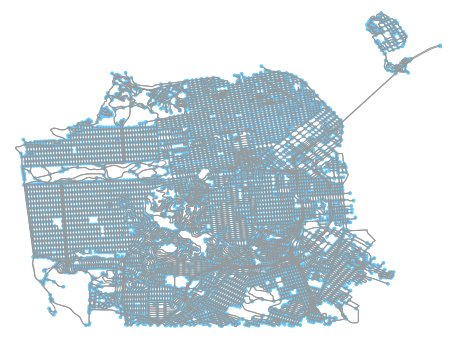

06_CA_0667000_San_Francisco


In [4]:
G = ox.load_graphml(graph_dir + graph_fname)
fig, ax = ox.plot_graph(G)
print(G.graph['name'])

In [5]:
print(G.number_of_nodes())
print(G.number_of_edges())

9367
26324


In [6]:
# osmid column has multiple ids for some roads, this puts single
# ids in a list so that the column has uniform "type" [Int]
def make_uniform_osmid(ids):
    if type(ids) == int:
        return [ids]
    else:
        return ids
    
# lanes are repr as strs and lists of strs, this makes them
# all a single integer representing the max number of lanes
def make_uniform_lanes(lanes):
    if type(lanes) == list:
        return np.mean([float(l) for l in lanes])
    else:
        return float(lanes)
    
def parse_maxspeed(speed):
    if type(speed) == str:
        if speed[-4:] == ' mph':
            return float(speed[:-4])
    return np.NaN
    
gdf_nodes, gdf_edges = ox.save_load.graph_to_gdfs(G)
gdf_edges['osmid'] = gdf_edges['osmid'].map(make_uniform_osmid)
gdf_edges['lanes'] = gdf_edges['lanes'].map(make_uniform_lanes)
gdf_edges['maxspeed'] = gdf_edges['maxspeed'].map(parse_maxspeed)

In [7]:
gdf_nodes.dtypes

y           float64
x           float64
osmid         int64
highway      object
ref          object
geometry     object
dtype: object

In [8]:
gdf_edges.dtypes

u              int64
v              int64
key            int64
osmid         object
bridge        object
oneway          bool
lanes        float64
ref           object
name          object
highway       object
maxspeed     float64
length       float64
geometry    geometry
junction      object
width         object
access        object
tunnel        object
service       object
dtype: object

## Load Movement Data

In [9]:
#fname = "./data/movement_data/movement-speeds-hourly-san-francisco-2019-6.csv.zip"
fname = "./data/movement_data/movement-speeds-quarterly-by-hod-san-francisco-2019-Q2.csv.zip"

%time df_raw = pd.read_csv(fname, engine='c', compression='zip')

CPU times: user 8.53 s, sys: 587 ms, total: 9.12 s
Wall time: 9.13 s


In [10]:
df = df_raw
print("Rows in data: {}".format(len(df)))
df = df[(df['year'] == 2019) &
        (df['quarter'] == 2) &
        (df['hour_of_day'] == 12)]
print("Rows in day data: {}".format(len(df)))

Rows in data: 5474129
Rows in day data: 253627


In [11]:
df.head()

,year,quarter,hour_of_day,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_mph_mean,speed_mph_stddev,speed_mph_p50,speed_mph_p85
10,2019,2,12,8f4827ebed3c2e66f50daef967d5e91daadd8d98,8e555723c3dff79036c7a8c0cef6b32a80763c9f,2278ad9374ec96c35a0d769bc8a275f6355b55da,40722998,62385707,4927951349,17.793,6.714,18.612,24.959
37,2019,2,12,aa884b48dd741bb591001ed9d77aaac9f4466048,7fe20e98f1cf38b3825fb4cb5bf10a7088834462,8bbd97259361a23d374e60e6582019550fc58e0f,87223163,1014244242,1014244233,22.583,2.306,22.001,25.320
53,2019,2,12,f32dbf217023581f429d56330be2a16410bc2809,8aaf6ad421333ad741cb1d5de1e3fa83e7d0e908,8bbd97259361a23d374e60e6582019550fc58e0f,417094233,4714793573,1014244233,27.389,4.533,27.706,31.219
70,2019,2,12,9d2084bc7090e387df9866d22b383f2537c40628,e08d4f15ac0eb1ce777ea2d54efaf6ffa2c3c30e,492441475679f95357fbeefc00a9e49c544081c0,416137931,239464357,4318478540,24.707,3.546,24.622,27.985
94,2019,2,12,b51e0d015f2a7d9a417746aaae39bbdbfd47a6be,7c4361ada161cd0725a010cdbd44d0213a6f9efc,492441475679f95357fbeefc00a9e49c544081c0,416137931,4169719264,4318478540,26.163,3.917,25.869,29.541


## Join Data

### Inspect Node Overlap

In [12]:
nodes_in_data = set(df['osm_start_node_id']) | set(df['osm_end_node_id'])
print("Movement data for {} nodes".format(len(nodes_in_data)))
nodes_in_graph = set(gdf_nodes['osmid'])
print("Graph data for {} nodes".format(len(nodes_in_graph)))

Movement data for 158218 nodes
Graph data for 9367 nodes


In [13]:
print("intersection: {}".format(len(nodes_in_data & nodes_in_graph)))
print("graph not data: {}".format(len(nodes_in_graph - nodes_in_data)))
print("data not graph: {}".format(len(nodes_in_data - nodes_in_graph)))

intersection: 7465
graph not data: 1902
data not graph: 150753


### Inspect Edge Overlap

In [14]:
edges_in_graph = set([e for es in gdf_edges['osmid'] for e in es])
print("Graph data for {} edges".format(len(edges_in_graph)))
edges_in_data = set(df['osm_way_id'])
print("Movement data for {} edges".format(len(edges_in_data)))

Graph data for 10429 edges
Movement data for 83662 edges


In [15]:
print("intersection: {}".format(len(edges_in_graph & edges_in_data)))
print("graph not data: {}".format(len(edges_in_graph - edges_in_data)))
print("data not graph: {}".format(len(edges_in_data - edges_in_graph)))

intersection: 7993
graph not data: 2436
data not graph: 75669


### Inspect Node Pairs Overlap

In [16]:
pairs_in_graph = set(list(zip(gdf_edges['u'], gdf_edges['v'])))
print("Graph data for {} pairs".format(len(pairs_in_graph)))
pairs_in_data = set(list(zip(df['osm_start_node_id'], df['osm_end_node_id'])))
print("Movement data for {} pairs".format(len(pairs_in_data)))

Graph data for 26248 pairs
Movement data for 253569 pairs


In [17]:
print("intersection: {}".format(len(pairs_in_graph & pairs_in_data)))
print("graph not data: {}".format(len(pairs_in_graph - pairs_in_data)))
print("data not graph: {}".format(len(pairs_in_data - pairs_in_graph)))

intersection: 13344
graph not data: 12904
data not graph: 240225


### Join Data on Edge Overlaps

In [18]:
# expand graph edges dataframe w/ one osmid per row
# note call to DataFrame since explode doesn't seem to work with GeoDataFrame
gdf_expanded_edges = pd.DataFrame(gdf_edges).explode('osmid')
gdf_expanded_edges.head(3)

,u,v,key,osmid,bridge,oneway,lanes,ref,name,highway,maxspeed,length,geometry,junction,width,access,tunnel,service
0,32927563,645559609,0,50690291,yes,True,5.0,I 80,San Francisco – Oakland Bay Bridge,motorway,50.0,3232.317,"LINESTRING (-122.39094 37.78592, -122.39037 37...",NaN,NaN,NaN,NaN,NaN
0,32927563,645559609,0,179235221,yes,True,5.0,I 80,San Francisco – Oakland Bay Bridge,motorway,50.0,3232.317,"LINESTRING (-122.39094 37.78592, -122.39037 37...",NaN,NaN,NaN,NaN,NaN
1,32927591,315706881,0,28715659,NaN,True,1.0,NaN,NaN,motorway_link,NaN,446.491,"LINESTRING (-122.42541 37.73138, -122.42510 37...",NaN,NaN,NaN,NaN,NaN


In [19]:
# merge on osm way ids
gdf_expanded_edges_merged = gdf_expanded_edges.merge(
    df,
    left_on='osmid',
    right_on='osm_way_id',
    how='left')

# take means across duplicate edges
gdf_edges_merged = gdf_expanded_edges_merged.groupby(
    ['u', 'v', 'key']).mean().reset_index()

# merge speeds back into original edge data
gdf_edges_merged = gdf_edges.merge(
    gdf_edges_merged[['u', 'v', 'key',
                      'speed_mph_mean',
                      'speed_mph_stddev',
                      'speed_mph_p50',
                      'speed_mph_p85']],
    on=['u', 'v', 'key'],
    validate='one_to_one')

In [20]:
gdf_edges_merged.head()

,u,v,key,osmid,bridge,oneway,lanes,ref,name,highway,...,geometry,junction,width,access,tunnel,service,speed_mph_mean,speed_mph_stddev,speed_mph_p50,speed_mph_p85
0,32927563,645559609,0,"[50690291, 179235221]",yes,True,5.0,I 80,San Francisco – Oakland Bay Bridge,motorway,...,"LINESTRING (-122.39094 37.78592, -122.39037 37...",NaN,NaN,NaN,NaN,NaN,37.106333,10.888000,38.911333,46.936000
1,32927591,315706881,0,[28715659],NaN,True,1.0,NaN,NaN,motorway_link,...,"LINESTRING (-122.42541 37.73138, -122.42510 37...",NaN,NaN,NaN,NaN,NaN,57.479000,7.715000,56.605000,65.638000
2,32927591,764927373,0,[31487921],NaN,True,4.0,I 280,John F Foran Freeway,motorway,...,"LINESTRING (-122.42541 37.73138, -122.42505 37...",NaN,NaN,NaN,NaN,NaN,66.216000,6.202000,66.853000,72.231000
3,32927645,65331336,0,"[28846637, 8918870, 61424023]",yes,True,2.0,I 280,Southern Embarcadero Freeway,motorway,...,"LINESTRING (-122.41331 37.73267, -122.41203 37...",NaN,NaN,NaN,NaN,NaN,60.663000,6.366333,61.199333,66.522333
4,32927645,766946830,0,"[8915137, 33645923, 33645968, 28656664, 61424026]",yes,True,2.0,NaN,NaN,motorway_link,...,"LINESTRING (-122.41331 37.73267, -122.41207 37...",NaN,NaN,NaN,NaN,NaN,49.382800,13.333800,53.845200,60.384200


In [21]:
gdf_edges_merged.shape

(26324, 22)

In [22]:
gdf_edges.shape

(26324, 18)

In [23]:
print("{}/{} edges have speed data".format(
    (~gdf_edges_merged['speed_mph_mean'].isna()).sum(),
    len(gdf_edges_merged['speed_mph_mean'])))

20584/26324 edges have speed data


## Rebuild Graph and Examine

In [24]:
G = ox.save_load.gdfs_to_graph(gdf_nodes, gdf_edges_merged)

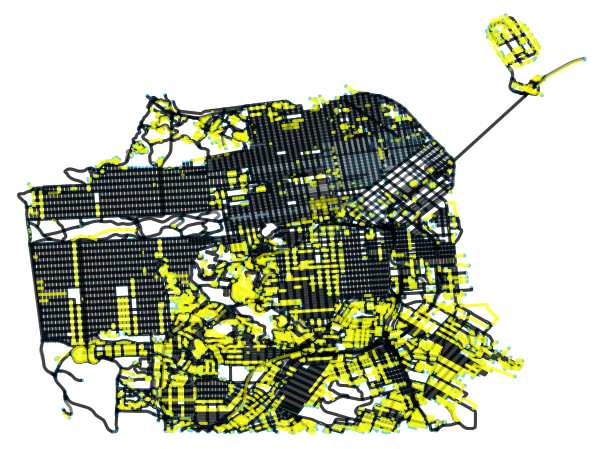

In [25]:
ec = ['black' if 'speed_mph_mean' in d.keys() else 'yellow' for (u,v,d) in G.edges(data=True)]
ez = [3 if 'speed_mph_mean' in d.keys() else 4 for (u,v,d) in G.edges(data=True)]

fig, ax = plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=0.5, edge_zorder=ez)

In [71]:
#Turn into Line Graph and carry over node and edge attributes
G = nx.Graph(G)
LG = nx.line_graph(G)

node_feature_list = ['speed_mph_p50','speed_mph_p85', 'speed_mph_stddev','speed_mph_mean', 'length', 'lanes', 'oneway']
edge_feature_list = ['x','y']

lg_node_attr = {}
node_relabel = {}

IDs = {}
cur_ID = 0

#To make torch_geometric.data extraction easier, remove every node that doesn't have ALL of the features in node_feature_list
remove = []
insert = []
for key,_ in LG.nodes(data=True):
    new_edge_data = G.get_edge_data(key[0],key[1])
    skip = False
    for k in list(new_edge_data.keys()):
        if k not in node_feature_list:
            del new_edge_data[k]
    for k in node_feature_list:
        if k not in new_edge_data:
            skip = True
            break
    if skip == True:
        remove.append(key)
        continue
    lg_node_attr[cur_ID] = G.get_edge_data(key[0],key[1])
    node_relabel[key] = cur_ID
    IDs[cur_ID] = key
    cur_ID+=1
    
for i in remove:
    LG.remove_node(i)
    
nx.relabel.relabel_nodes(LG,node_relabel,False)
    
nx.set_node_attributes(LG,lg_node_attr)

lg_edge_attr = {}
remove = []
insert = []
    
def my_parse(u):
    u = u[1:]
    u = u[:len(u)-1]
    u = u.split(',')
    u[1] = u[1].split()
    return (int(u[0]),int(u[1][0]))
for u,v in LG.edges():
    e1 = IDs[u]
    e2 = IDs[v]
    G_intersect_node = tuple(set(e1) & set(e2))
    remove.append((u,v))
    if len(G_intersect_node) == 1:
        insert.append((u,v))
        new_node_data = G.nodes[G_intersect_node[0]]
        for k in list(new_node_data.keys()):
            if k not in edge_feature_list:
                del new_node_data[k]
        lg_edge_attr[(u,v)] = G.nodes[G_intersect_node[0]]
    #Ignore case of one way streets (when len(G_intersect_node) == 2)
for i in remove:
    LG.remove_edge(i[0],i[1])
    
for i in insert:
    LG.add_edge(i[0],i[1])
nx.set_edge_attributes(LG,lg_edge_attr)
for n in LG.nodes(data=True):
    print(n)
    break
print('\n')
for e in LG.edges(data=True):
    print(e)
    break


pyData = from_networkx(LG)
print(pyData)

(285, {'oneway': False, 'lanes': 2.0, 'length': 98.994, 'speed_mph_mean': 10.695124999999999, 'speed_mph_stddev': 5.125875, 'speed_mph_p50': 9.983875, 'speed_mph_p85': 15.61075})


(285, 211, {'y': 37.7923918, 'x': -122.4210673})
Data(edge_index=[2, 14240], lanes=[4613], length=[4613], oneway=[4613], speed_mph_mean=[4613], speed_mph_p50=[4613], speed_mph_p85=[4613], speed_mph_stddev=[4613], x=[14240], y=[14240])


In [53]:
#This cell is used to obtain the edge list of the line graph. Does not have proper attributes for nodes and edges.
#The above cell does this
G = nx.Graph(G)
LG = nx.line_graph(G)

#New Ids are used starting at zero to prevent overflow problem when using snap node2vec
#IDs: 
#key: new ID
#Value: old line graph node key
IDs = {}
cur_ID = 0



lg_node_attr = {}
node_relabel = {}
previous = []
new = []
for key,_ in LG.nodes(data=True):
    previous.append(key)
    new.append(str(key))
    node_relabel[key] = cur_ID
    lg_node_attr[cur_ID] = G.get_edge_data(key[0],key[1])
    IDs[cur_ID] = key
    cur_ID+=1
    

nx.relabel.relabel_nodes(LG,node_relabel,False)
    
nx.set_node_attributes(LG,lg_node_attr)
        
lg_edge_attr = {}
remove = []
insert = []

for u,v in LG.edges():
    e1 = IDs[u]
    e2 = IDs[v]
    G_intersect_node = tuple(set(e1) & set(e2))
    remove.append((u,v))
    if len(G_intersect_node) == 1:
        insert.append((u,v))
        lg_edge_attr[(u,v)] = G.nodes[G_intersect_node[0]]
    #Ignore case of one way streets (when len(G_intersect_node) == 2)
for i in remove:
    LG.remove_edge(i[0],i[1])
    
for i in insert:
    LG.add_edge(i[0],i[1])
#nx.set_edge_attributes(LG,lg_edge_attr)
#for key in LG.nodes(data=True):
#    print(key)
#print(torch.tensor(list(LG.edges)))
nx.readwrite.edgelist.write_edgelist(LG, 'snap/examples/node2vec/streets.edgelist', data=False)


#for e in LG.edges(data=True):
#    print(e)
#    break



#pyData = from_networkx(LG)
#print(pyData.num_edge_features)

{'oneway': False, 'name': 'Macondray Lane', 'length': 75.108}
33242031 65292114
65292114 65312672
65292114 65345273


In [ ]:
#This cell is used to obtain the edge list of the line graph. Does not have proper attributes for nodes and edges.
#The above cell does this
G = nx.Graph(G)
LG = nx.line_graph(G)

#New Ids are used starting at zero to prevent overflow problem when using snap node2vec
#IDs: 
#key: new ID
#Value: old line graph node key
IDs = {}
cur_ID = 0



lg_node_attr = {}
node_relabel = {}
previous = []
new = []
for key,_ in LG.nodes(data=True):
    previous.append(key)
    new.append(str(key))
    node_relabel[key] = cur_ID
    lg_node_attr[cur_ID] = G.get_edge_data(key[0],key[1])
    IDs[cur_ID] = key
    cur_ID+=1
    

nx.relabel.relabel_nodes(LG,node_relabel,False)
    
nx.set_node_attributes(LG,lg_node_attr)

print(G.edges()[(33242031,65292114)])

for u,v in G.edges():
    if (u == 33242031 or u == 65292114) or (v == 33242031 or v == 65292114):
        print(u,v)
        
lg_edge_attr = {}
remove = []
insert = []
    
for u,v in LG.edges():
    e1 = IDs[u]
    e2 = IDs[v]
    G_intersect_node = tuple(set(e1) & set(e2))
    remove.append((u,v))
    if len(G_intersect_node) == 1:
        insert.append((u,v))
        lg_edge_attr[(u,v)] = G.nodes[G_intersect_node[0]]
    #Ignore case of one way streets (when len(G_intersect_node) == 2)
for i in remove:
    LG.remove_edge(i[0],i[1])
    
for i in insert:
    LG.add_edge(i[0],i[1])
#nx.set_edge_attributes(LG,lg_edge_attr)
#for key in LG.nodes(data=True):
#    print(key)
#print(torch.tensor(list(LG.edges)))
nx.readwrite.edgelist.write_edgelist(LG, 'snap/examples/node2vec/streets.edgelist', data=False)


#for e in LG.edges(data=True):
#    print(e)
#    break



#pyData = from_networkx(LG)
#print(pyData.num_edge_features)